## Importing Data

In [1]:
import pandas as pd

### Import .csv file with the Olympics data

In [2]:
events = pd.read_csv("athlete_events.csv")
events.head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN


### Read in data to create NOC-Country dictionary

In [3]:
dic1 = pd.read_html("https://en.wikipedia.org/wiki/List_of_IOC_country_codes")[0].drop(columns = ["Other codes used", "Link"])
dic1.at[0,'Code'] = "AFG"
dic1.columns = ['Code', 'Country']
dic2 = pd.read_html("https://en.wikipedia.org/wiki/List_of_IOC_country_codes")[2].drop(columns = "Other codes used")
dic2.columns = ['Code', 'Country']
dic3 = pd.read_html("https://en.wikipedia.org/wiki/List_of_IOC_country_codes")[3].drop(columns = ["Years", "Notes", "Unnamed: 4"])
dic3.columns = ['Code', 'Country']
dic4 = pd.read_html("https://en.wikipedia.org/wiki/List_of_IOC_country_codes")[4].drop(columns = ["Years", "Notes"])
dic4.columns = ['Code', 'Country']
pdList = [dic1, dic2, dic3, dic4]
countries = pd.concat(pdList)
new_rows = [{'Code':'LIB', 'Country':"Lebanon"}, {'Code':'WIF', 'Country':"WIF"} ]
countries = countries.append(new_rows, ignore_index=True)
countries.head(1)

,Code,Country
0,AFG,Afghanistan


### Merge the 2 tables and create a "medals" dataset including only the medal winners

In [4]:
events_ = pd.merge(events, countries, how="left", left_on = "NOC", right_on="Code")
events_.head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Code,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,CHN,China


In [5]:
medals = events_[events_.Medal.notnull()].reset_index().drop(columns = ["index", "ID", "NOC", "Team"])
medals.Medal = medals.Medal.astype("category")
medals.Medal.cat.set_categories(["Bronze", "Silver", "Gold"], ordered = True, inplace = True)
medals.head(1)

,Name,Sex,Age,Height,Weight,Games,Year,Season,City,Sport,Event,Medal,Code,Country
0,Edgar Lindenau Aabye,M,34.0,NaN,NaN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,DEN,Denmark


### Create GDP, Elevation and Temperature tables

In [6]:
gdp = pd.read_html("https://worldpopulationreview.com/countries/countries-by-gdp")[0].drop(columns = ["GDP (IMF '19)", "Rank", "GDP (UN '16)"])
gdp.columns = ['Country','GDP','Population']
gdp["GDP"] = gdp["GDP"].str.replace(',', '')
gdp["GDP"] = gdp["GDP"].str.replace('$', '')
gdp["GDP"] = pd.to_numeric(gdp["GDP"])
gdp.set_index("Country", inplace=True)
gdp.head(1)

,GDP,Population
Country,,
United States,67063,331002651


In [7]:
elevation = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_by_average_elevation")[1]
elevation.drop(158, axis = 0, inplace = True)
elevation['Elevation'] = elevation['Elevation'].str.split(r' ').str.get(0)
elevation['Elevation'] = elevation['Elevation'].str.replace('m', '')
elevation['Elevation'] = elevation['Elevation'].str.replace(',', '')
elevation['Elevation'] = elevation['Elevation'].str.strip()
elevation['Elevation'] = pd.to_numeric(elevation['Elevation'])
elevation.set_index("Country", inplace=True)
elevation.rename(index={'Czechia':'Czech Republic'},inplace=True)
elevation.head(1)

,Elevation
Country,
Afghanistan,1885.0


In [8]:
temperature = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature")[0]
temperature.columns = ["Country", "Temperature"]
temperature['Temperature'] = temperature['Temperature'].str.replace('−', '-')
temperature["Temperature"] = pd.to_numeric(temperature["Temperature"], downcast='float')
temperature.set_index("Country", inplace=True)
temperature.head(1)

,Temperature
Country,
Burkina Faso,28.290001


## Medals per country - aggregated dataframe

In [9]:
sum_vs_win = pd.crosstab(medals.Country, medals.Season)
men_vs_women = pd.crosstab(medals.Country, medals.Sex)
medals_by_cats = pd.concat([sum_vs_win, men_vs_women], axis = 1)
medals_by_cats.head(3)

,Summer,Winter,F,M
Country,,,,
Afghanistan,2,0,0,2
Algeria,17,0,3,14
Argentina,274,0,73,201


In [10]:
medals_per_country = pd.crosstab(index = medals.Country, columns = medals.Medal, 
                                 margins = True, margins_name= "Total")
medals_per_country.drop("Total", axis = 0, inplace = True)
medals_per_country = medals_per_country.merge(gdp, how="left", left_index=True, on="Country")
medals_per_country = medals_per_country.merge(elevation, how="left", left_index=True, on="Country")
medals_per_country = pd.merge(medals_per_country, temperature, how="left", on="Country")
medals_per_country = pd.merge(medals_per_country, medals_by_cats, how="left", on="Country")

In [11]:
medals_per_country.head(3)

,Bronze,Silver,Gold,Total,GDP,Population,Elevation,Temperature,Summer,Winter,F,M
Country,,,,,,,,,,,,
Afghanistan,2,0,0,2,531.0,38928346.0,1885.0,12.600000,2,0,0,2
Algeria,8,4,5,17,4403.0,43851044.0,800.0,18.790001,17,0,3,14
Argentina,91,92,91,274,11403.0,45195774.0,595.0,14.800000,274,0,73,201


In [12]:
top_20 = medals.Country.value_counts().head(20).index
sports = medals.Sport.value_counts().index

In [13]:
by_sport = pd.crosstab(medals.Country, medals.Sport)
by_sport = by_sport.rank(ascending = False, method = "average")

In [14]:
by_sport = by_sport.loc[top_20, sports].copy()

## Ranking the values to get a relative value.

In [15]:
medals_per_country.sort_values("Total", ascending = False, inplace = True)
ranks = medals_per_country.rank(ascending = False, method = "average")
top_50 = ranks.head(50)

## Charts

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

### Top countries by edition

In [17]:
top_15 = medals.Country.value_counts().head(15)
olympics_15 = medals[medals.Country.isin(top_15.index)]

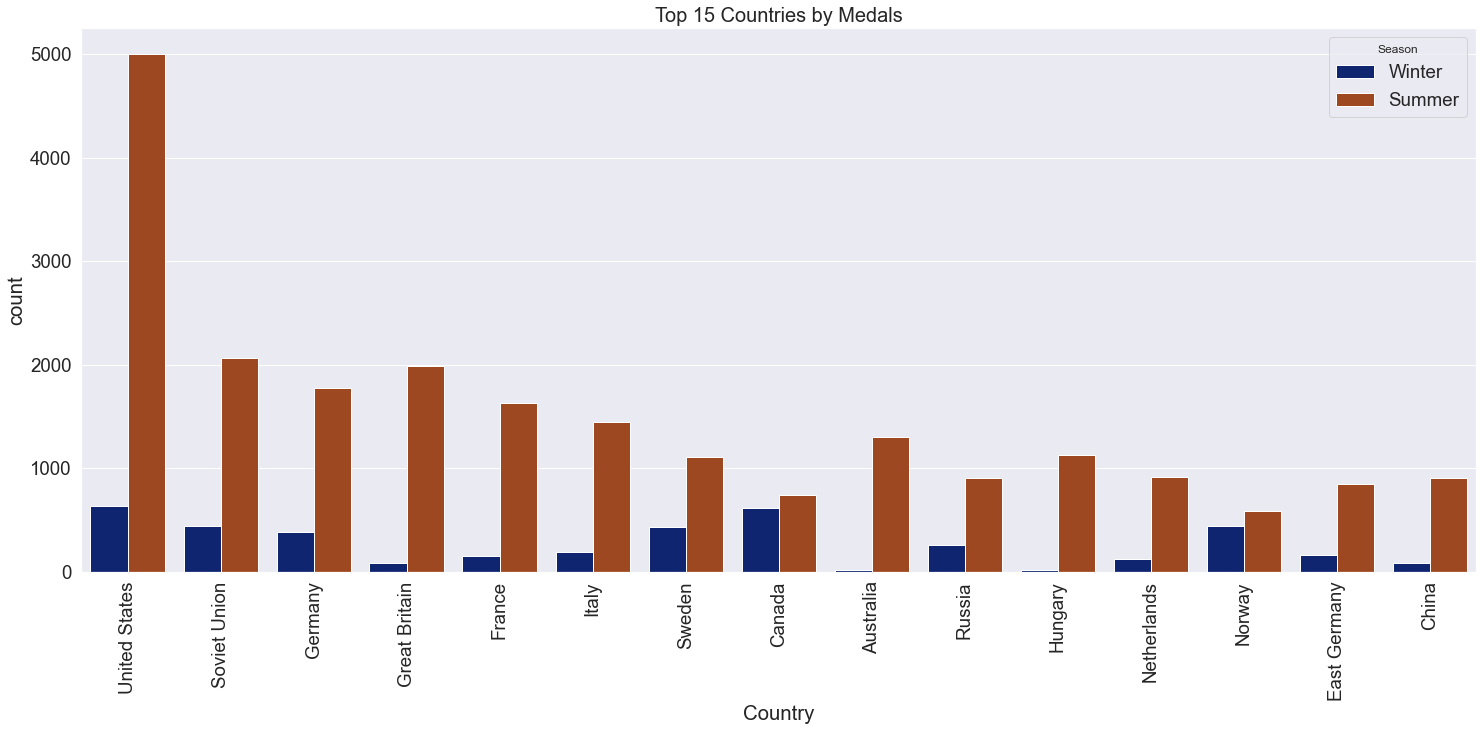

In [18]:
plt.figure(figsize=(25,10))
sns.set(font_scale=1.7, palette= "dark")
sns.countplot(data = olympics_15, x = "Country", hue = "Season", order = top_15.index)
plt.xticks(rotation=90)
plt.title("Top 15 Countries by Medals", fontsize = 20)
plt.show()

### Differences in genders and editions

In [19]:
seasonal_rank_diff = top_50.Summer.sub(top_50.Winter).sort_values().to_frame()

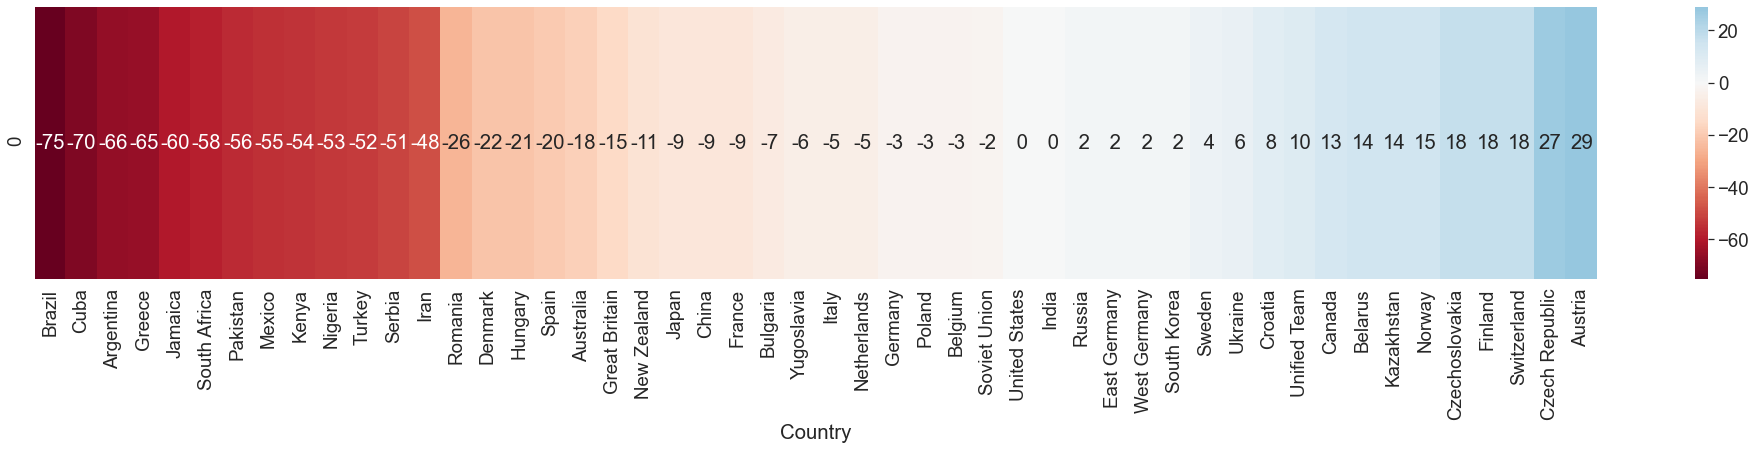

In [20]:
plt.figure(figsize = (35, 5))
sns.heatmap(seasonal_rank_diff.T,cmap='RdBu',annot=True,fmt='2.0f', center = 0)
plt.show()

In [21]:
gender_rank_diff = top_50.M.sub(top_50.F).sort_values().to_frame()

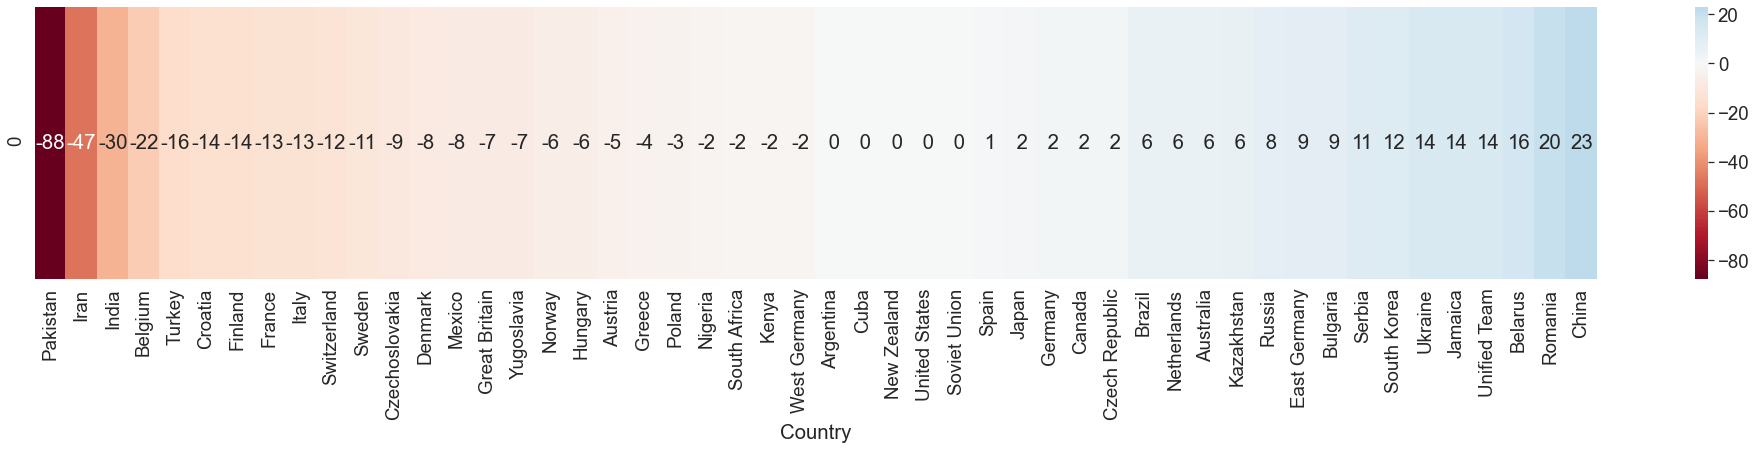

In [22]:
plt.figure(figsize = (35, 5))
sns.heatmap(gender_rank_diff.T,cmap='RdBu',annot=True,fmt='2.0f', center = 0)
plt.show()

### Charts on the final dataset

In [23]:
top50corr = medals_per_country.head(50).corr(method = "spearman").iloc[3:,3:]
top50corr

,Total,GDP,Population,Elevation,Temperature,Summer,Winter,F,M
Total,1.000000,0.750982,0.033827,-0.254766,-0.406389,0.975414,0.785497,0.904271,0.961439
GDP,0.750982,1.000000,-0.330263,-0.206139,-0.553735,0.668982,0.740703,0.604825,0.792192
Population,0.033827,-0.330263,1.000000,0.415751,0.335775,0.107067,-0.101767,0.056405,0.028543
Elevation,-0.254766,-0.206139,0.415751,1.000000,0.136135,-0.292672,-0.162420,-0.259307,-0.225411
Temperature,-0.406389,-0.553735,0.335775,0.136135,1.000000,-0.289782,-0.724404,-0.413429,-0.378776
Summer,0.975414,0.668982,0.107067,-0.292672,-0.289782,1.000000,0.662624,0.899806,0.926239
Winter,0.785497,0.740703,-0.101767,-0.162420,-0.724404,0.662624,1.000000,0.689676,0.777540
F,0.904271,0.604825,0.056405,-0.259307,-0.413429,0.899806,0.689676,1.000000,0.787212
M,0.961439,0.792192,0.028543,-0.225411,-0.378776,0.926239,0.777540,0.787212,1.000000


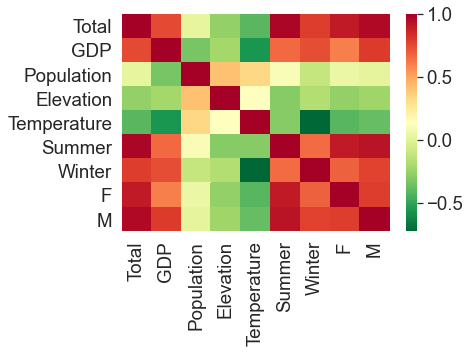

In [24]:
sns.heatmap(top50corr,cmap='RdYlGn_r')

#### Observations from the heatmap:
- Positive correlation between : Total medals and GDP
- Negative correlation between : Winter medals and Averagre Temperature

In [25]:
medals_per_country.head(1)

,Bronze,Silver,Gold,Total,GDP,Population,Elevation,Temperature,Summer,Winter,F,M
Country,,,,,,,,,,,,
United States,1358,1641,2638,5637,67063.0,331002651.0,760.0,8.55,5002,635,1805,3832


In [26]:
top50_ranks = medals_per_country.rank(ascending = False, method = "average").head(50)

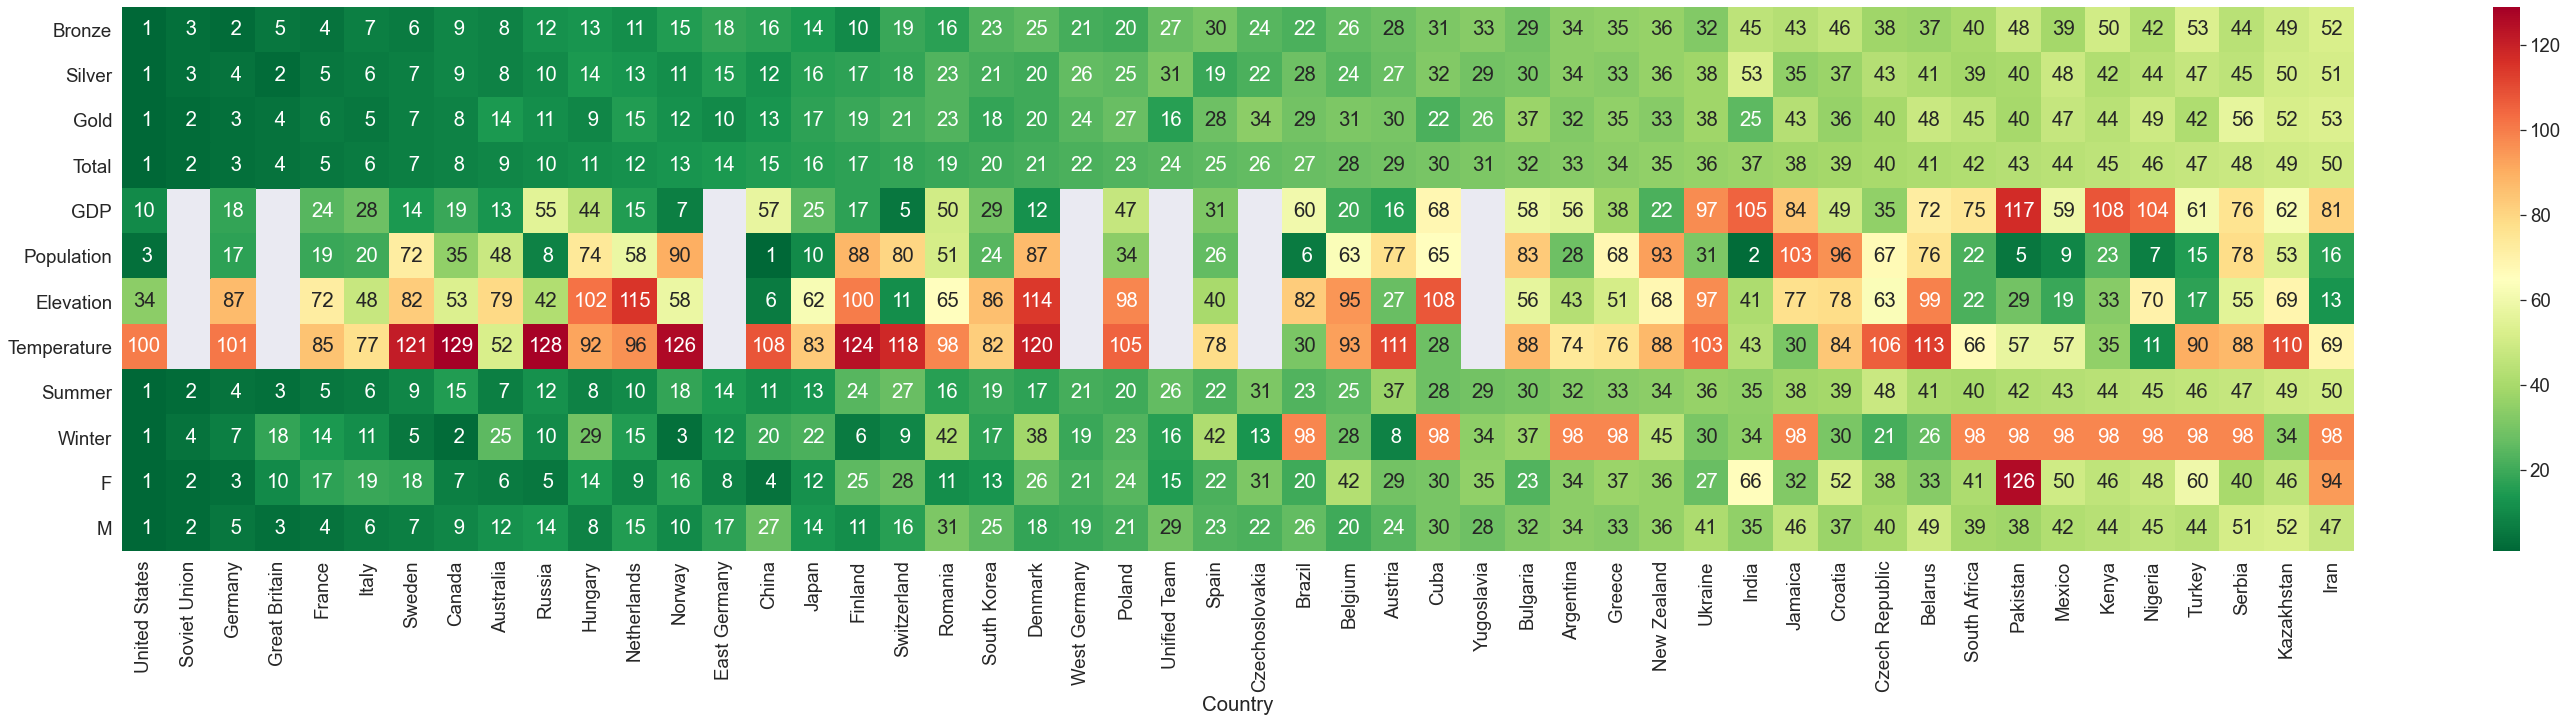

In [27]:
plt.figure(figsize = (50, 10))
sns.heatmap(top50_ranks.T,cmap='RdYlGn_r',annot=True,fmt='2.0f')
plt.show()

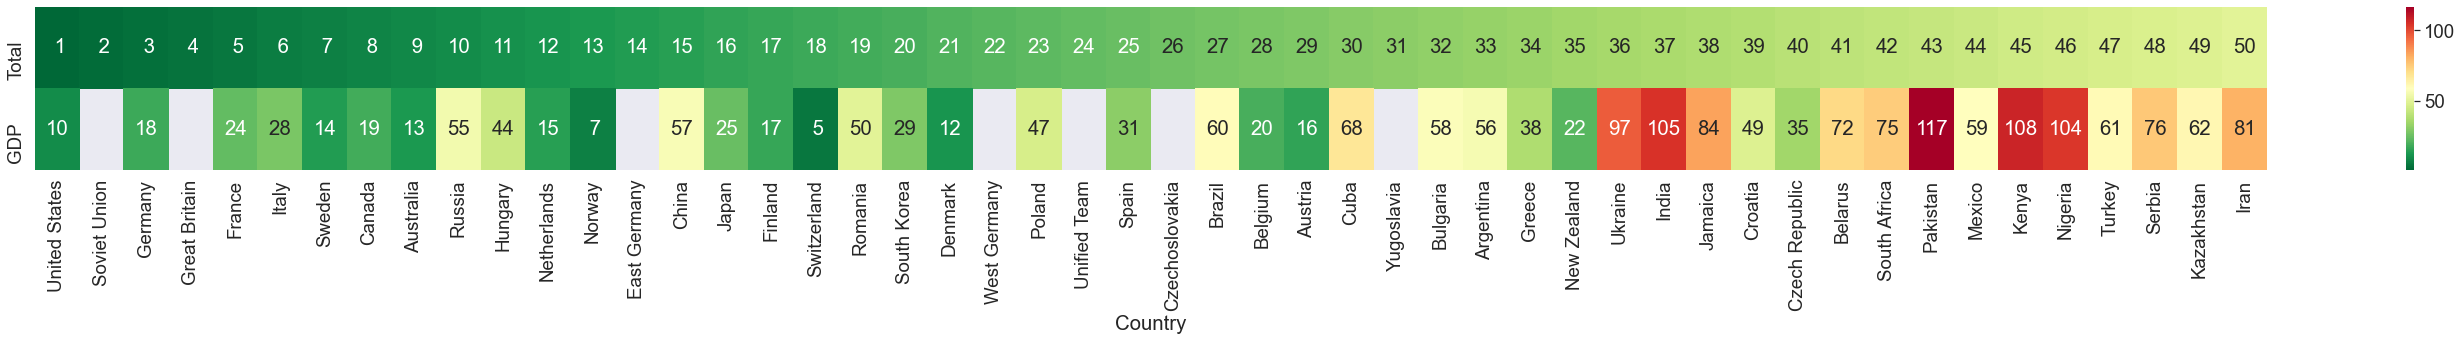

In [28]:
plt.figure(figsize = (50, 3))
sns.heatmap(top50_ranks[["Total", "GDP"]].T,cmap='RdYlGn_r',annot=True,fmt='2.0f')
plt.show()

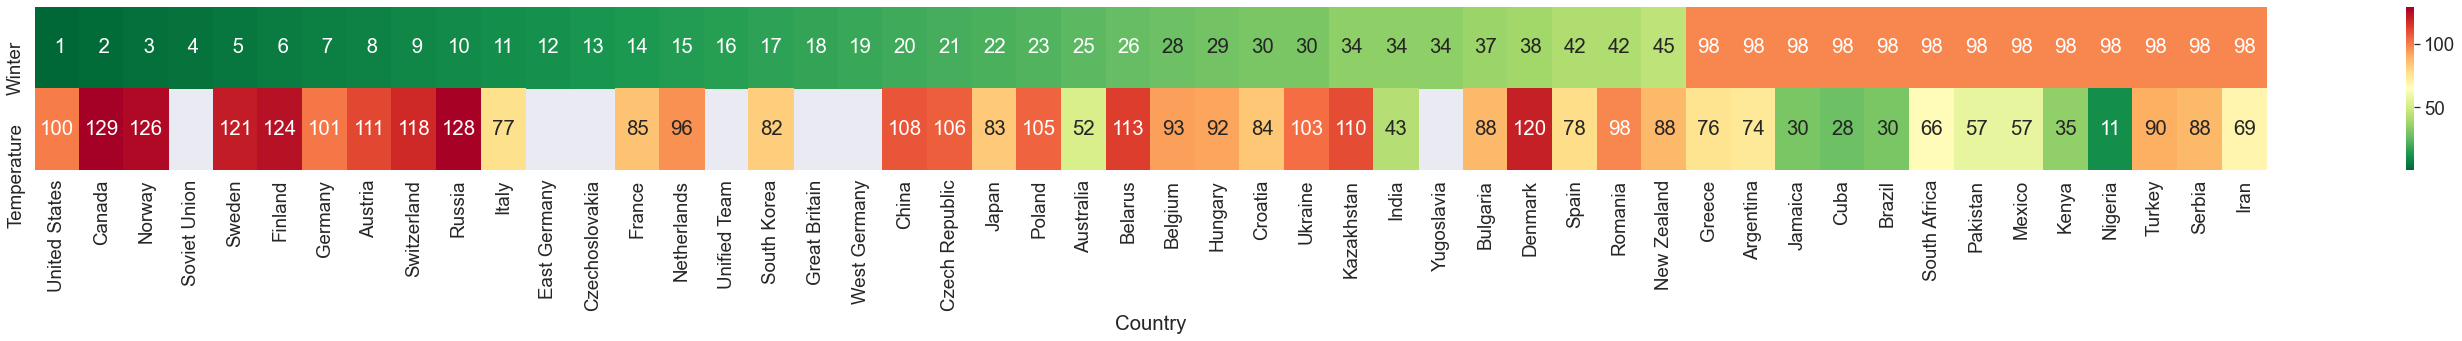

In [29]:
plt.figure(figsize = (50, 3))
sns.heatmap(top50_ranks[["Winter", "Temperature"]].sort_values(by = "Winter").T,cmap='RdYlGn_r',annot=True,fmt='2.0f')
plt.show()

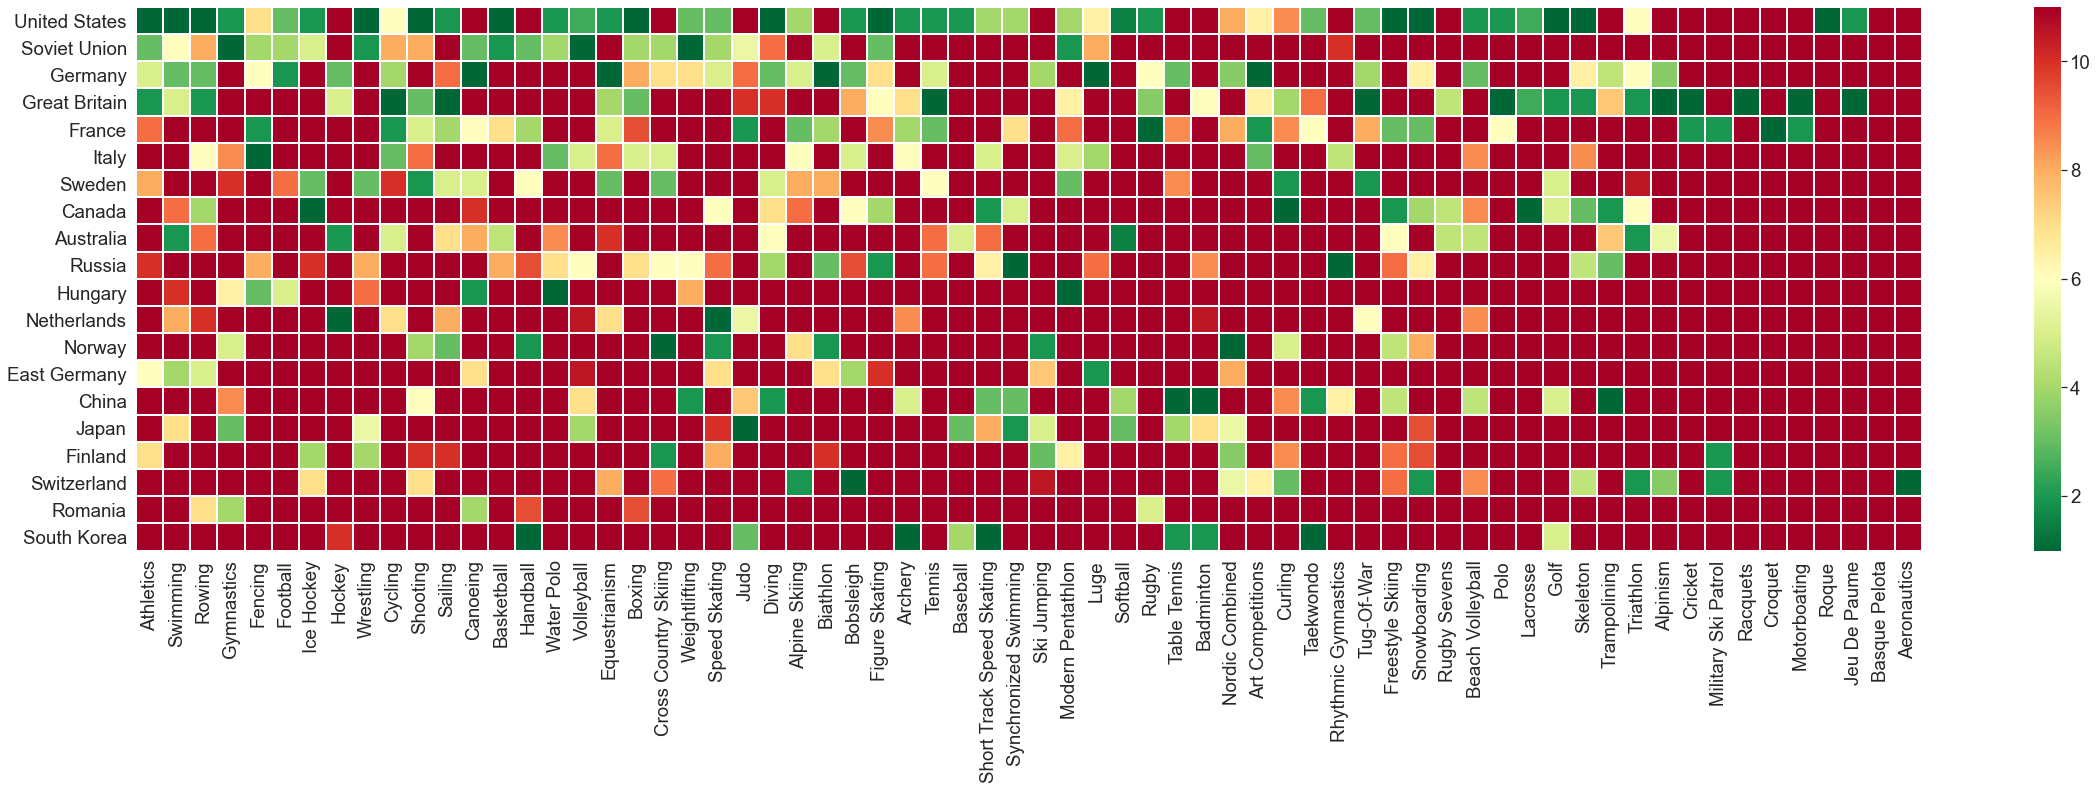

In [30]:
plt.figure(figsize = (40, 10))
sns.heatmap(by_sport,cmap='RdYlGn_r', vmin = 1, vmax =11, linewidth = 1) #could be vmax=21
plt.show()